In [72]:
import warnings
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score, PrecisionRecallDisplay, RocCurveDisplay

from joblib import dump,load

In [4]:
# Load the mapping_sleep dictionary from the pickle file
with open('mapping_sleep.pkl', 'rb') as f:
    mapping_sleep = pickle.load(f)
    
# Load the mapping_sleep dictionary from the pickle file
with open('mapping_diet.pkl', 'rb') as f:
    mapping_diet = pickle.load(f)
    
# Load the data 
df = pd.read_csv('train.csv')

In [5]:
cols_te_drop = ['id', 'Name', 'City', 'Profession', 'CGPA', 'Degree', 'Work Pressure', 'Academic Pressure', 
                'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits']

In [6]:
def data_prep(df,
              col1 = 'Academic Pressure',
              col2 = 'Work Pressure',
              col3 = 'Study Satisfaction',
              col4 = 'Job Satisfaction',
              col_drop = cols_te_drop):
    '''
    Step 1: Combines Study and Work Pressure into one column
    Step 2: Creates sleep_dur_cat by grouping incorrect leep Duration levels
    Step 3: Creates Diet_cat by grouping incorrect leep Duration levels
    Step 4: Renaming columns
    Step 5: Drop irrelevant columns
    
    '''
    
    df['academic_work_pressure'] = np.maximum(df[col1].fillna(-np.inf), df[col2].fillna(-np.inf)).replace(-np.inf, np.nan)
    #df['academic_work_satisfaction'] = np.maximum(df[col3].fillna(-np.inf), df[col4].fillna(-np.inf)).replace(-np.inf, np.nan)
        
    # Step 2
    df['sleep_dur_cat'] = df['Sleep Duration'].map(mapping_sleep)
    
    # Step 3
    df['diet_cat'] = df['Dietary Habits'].map(mapping_diet)
    
    # Step 4
    df = df.rename(columns = {'Working Professional or Student': 'prof_or_student',
                              'Have you ever had suicidal thoughts ?': 'suicidal',
                              'Work/Study Hours': 'work_study_hours',
                              'Family History of Mental Illness': 'family_hist',
                              'Gender': 'gender',
                              'Age': 'age',
                              'Depression': 'depression',
                              'Financial Stress': 'financial_stress'})
    
    # Step 5
    df = df.drop(columns = col_drop, axis = 1)
    
    return df

In [7]:
df = data_prep(df,
          col1 = 'Academic Pressure',
          col2 = 'Work Pressure',
          col_drop = cols_te_drop)

df.head()

,gender,age,prof_or_student,suicidal,work_study_hours,financial_stress,family_hist,depression,academic_work_pressure,sleep_dur_cat,diet_cat
0,Female,49.0,Working Professional,No,1.0,2.0,No,0,5.0,High Sleep,Healthy
1,Male,26.0,Working Professional,Yes,7.0,3.0,No,1,4.0,Low Sleep,Unhealthy
2,Male,33.0,Student,Yes,3.0,1.0,No,1,5.0,Moderate Sleep,Healthy
3,Male,22.0,Working Professional,Yes,10.0,1.0,Yes,1,5.0,Low Sleep,Moderate
4,Female,30.0,Working Professional,Yes,9.0,4.0,Yes,0,1.0,Moderate Sleep,Unhealthy


## 1 Train\Test Split

This data has imbalanced target variables (depression) and predictors (prof_or_student), it’s essential to apply techniques that ensure both class balance and meaningful representation in both training and testing sets.

In [8]:
X = df.drop('depression', axis = 1)
y = df['depression']

#### Step 1: Split into Train + Temporary Set (Test + Holdout)

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, 
                                                    y, 
                                                    stratify = y, 
                                                    test_size = 0.4, 
                                                    random_state = 42)

In [10]:
y.value_counts()/len(y)

0    0.818287
1    0.181713
Name: depression, dtype: float64

In [11]:
y_train.value_counts()/len(y_train)

0    0.81829
1    0.18171
Name: depression, dtype: float64

In [12]:
X['prof_or_student'].value_counts()/len(X['prof_or_student'])

Working Professional    0.801699
Student                 0.198301
Name: prof_or_student, dtype: float64

In [13]:
X_train['prof_or_student'].value_counts()/len(X_train['prof_or_student'])

Working Professional    0.801575
Student                 0.198425
Name: prof_or_student, dtype: float64

#### Step 2: Split Temporary Set into Test and Holdout

In [14]:
X_test, X_holdout, y_test, y_holdout = train_test_split(X_temp, 
                                                        y_temp, 
                                                        stratify = y_temp,
                                                        test_size = 0.5,
                                                        random_state = 42)  # 20% test, 20% holdout

In [15]:
X_test['prof_or_student'].value_counts()/len(X_test['prof_or_student'])

Working Professional    0.802523
Student                 0.197477
Name: prof_or_student, dtype: float64

In [16]:
y_test.value_counts()/len(y_test)

0    0.818266
1    0.181734
Name: depression, dtype: float64

In [17]:
print(f'The shape of X_train is {X_train.shape}\nThe shape of X_test is {X_test.shape}\nThe shape of X_holdout is {X_holdout.shape}')

The shape of X_train is (84420, 10)
The shape of X_test is (28140, 10)
The shape of X_holdout is (28140, 10)


In [18]:
X_train_num = X_train[['age', 'work_study_hours']]
X_train_cat = X_train.drop(columns = ['age', 'work_study_hours'], axis = 1)
X_train_nom_cat = X_train_cat.drop(columns = ['financial_stress', 'academic_work_pressure'], axis = 1)
X_train_ord_cat = X_train_cat[['financial_stress', 'academic_work_pressure']]

num_attribs = X_train_num.columns
cat_attribs = X_train_cat.columns
nom_cat_attribs = X_train_nom_cat.columns
ord_cat_attribs = X_train_ord_cat.columns

**Ordinal Variables**:
* financial_stress
* academic_work_pressure

## 2 Training 

As part of the model training process, I will first establish a baseline performance using Logistic Regression, followed by training more advanced models such as Decision Trees, Random Forest, Gradient Boosting, KNN, and SVM.

In [19]:
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy = "median")),
                         ('std_scaler', StandardScaler())
                            ])

In [20]:
nom_cat_pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy = "most_frequent")),
                        ('onehot', OneHotEncoder(drop = 'first'))      # One-hot encode with drop first column
                            ])

In [21]:
ord_cat_pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy = "most_frequent")),
                        ('ordinal', OrdinalEncoder())      
                            ])

In [22]:
full_pipeline = ColumnTransformer([
                                    ("num", num_pipeline, num_attribs),
                                    ("nom_cat", nom_cat_pipeline, nom_cat_attribs),
                                    ("ord_cat", ord_cat_pipeline, ord_cat_attribs),
                                      ])

In [23]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)
X_holdout_prepared = full_pipeline.transform(X_holdout)

In [24]:
num_columns = list(num_attribs) 
ord_cat_columns = list(ord_cat_attribs)

# Extract the feature names for categorical columns after the pipeline
nom_cat_columns = full_pipeline.transformers_[1][1].named_steps['onehot'].get_feature_names_out(nom_cat_attribs)

# Combine numeric and categorical column names
all_columns = num_columns + list(nom_cat_columns) + ord_cat_columns


pd.DataFrame(X_train_prepared, columns = all_columns)

,age,work_study_hours,gender_Male,prof_or_student_Working Professional,suicidal_Yes,family_hist_Yes,sleep_dur_cat_Low Sleep,sleep_dur_cat_Moderate Sleep,sleep_dur_cat_Other,diet_cat_Moderate,diet_cat_Other,diet_cat_Unhealthy,financial_stress,academic_work_pressure
0,-0.433216,-1.622662,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
1,1.019098,-0.582668,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0
2,1.261151,-0.062671,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.271848,-1.362663,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0
4,-0.191164,1.237321,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84415,-0.755953,0.977322,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
84416,-1.724162,0.977322,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,4.0
84417,1.261151,0.977322,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
84418,1.583887,0.717324,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0


### 2.2 Training Models 

In [25]:
def evaluate_models(X_train, y_train, X_test, y_test, models, param):
    
    '''
    
    This function calculates the Accuracy for both Train and Test sets and for each model, 
    then return the results in Pandas DataFrame
    
    '''
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
    
    
    data = {}

    # Loop through models and their corresponding hyperparameters
    for model_name, model in models.items():
        # Get the hyperparameter grid for the current model
        para = param[model_name]

        # Perform GridSearchCV
        gs = GridSearchCV(model, para, cv = 5)
        gs.fit(X_train, y_train)

        # Make predictions using the best model from GridSearchCV
        y_train_pred = gs.predict(X_train)
        y_test_pred = gs.predict(X_test)
        
        
        # Calculate the Accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        
        # Add the results to the report dictionary for this model
        data[model_name] = {
                             'train_accuracy': train_accuracy,
                             'test_accuracy': test_accuracy
                                }
        
        # Now we take the dictionnary and create a nice data frame 
       
        report =  pd.DataFrame(data).T  # Transpose to make model names as rows

        report.rename(columns={'index': 'model_name'}, inplace = True)
        

    return report

In [26]:
models = {
            "Logistic Regression": LogisticRegression(max_iter= 1000),
            "LDA": LinearDiscriminantAnalysis(),
            "KNN": KNeighborsClassifier(),
            "Random Forest": RandomForestClassifier(),
            "XG Boost": XGBClassifier(),
            "CatBoost": CatBoostClassifier(verbose = 0),
            "SGDC": SGDClassifier(random_state=42)
            }

param = {
            "Logistic Regression":{
                
                                    },
            "LDA": {
                                'solver': ['svd', 'lsqr', 'eigen'],  # Solvers for LDA
                                'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Only applicable for 'lsqr' and 'eigen'
                                                },
             "KNN": {
                                'n_neighbors': [3, 5, 7, 9],
                                'weights': ['uniform', 'distance']
                                       },

            "Random Forest": {
                                'n_estimators': [10, 50],
                                'min_samples_split': [2, 5, 10]
                                    },
            "XG Boost": {
                                'n_estimators': [10, 50],
                                'max_depth': [3, 5, 7, 10],
                                'learning_rate': [0.01, 0.1, 0.2]
                                        },
            "CatBoost": {
                                'iterations': [500, 1000],         # Number of boosting iterations
                                'learning_rate': [0.01, 0.1, 0.2] # Learning rate

                                                },
            
            "SGDC": {}

            }

* Logistic Regression: A linear model for binary classification that predicts the probability of a data point belonging to a particular class. It uses the logistic function to map predictions to probabilities between 0 and 1.

* k-Nearest Neighbors (KNN): A non-parametric, instance-based algorithm that classifies a data point by looking at the classes of its k nearest neighbors. It assigns the most common class among them to the new data point.

* Support Vector Machine (SVM): A supervised algorithm that finds the optimal boundary (hyperplane) to separate data points of different classes with the widest possible margin, enhancing classification accuracy.

* Random Forest: An ensemble method that builds multiple decision trees on random subsets of the data and combines their predictions for improved accuracy and reduced overfitting.

* XGBoost: An advanced boosting algorithm that creates sequential trees, each correcting the errors of the previous ones, resulting in a strong classifier with high accuracy and efficiency in handling large datasets.

In [27]:
accuracy_table = evaluate_models(X_train_prepared, y_train, X_test_prepared, y_test, models, param)
accuracy_table

C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py", line 621, in fit
    raise NotImp

,train_accuracy,test_accuracy
Logistic Regression,0.934506,0.935004
LDA,0.930585,0.930633
KNN,0.940618,0.929922
Random Forest,0.955082,0.934613
XG Boost,0.938332,0.934968
CatBoost,0.936911,0.936780
SGDC,0.932504,0.933937


In [40]:
cb = CatBoostClassifier(verbose = 0)
params = {'iterations': [500, 1000],         # Number of boosting iterations
          'learning_rate': [0.01, 0.1, 0.2]} # Learning rate

# Perform GridSearchCV
gs = GridSearchCV(cb, params, cv = 5)
gs.fit(X_train_prepared, y_train)

# Get the best estimator from GridSearchCV
best_model = gs.best_estimator_
best_model

In [41]:
# Get the best estimator from GridSearchCV
best_model = gs.best_estimator_

# Access feature importances
feature_importances = best_model.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': all_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
0,age,36.146082
4,suicidal_Yes,19.606354
13,academic_work_pressure,12.589573
12,financial_stress,10.276819
3,prof_or_student_Working Professional,6.358744
1,work_study_hours,6.326852
11,diet_cat_Unhealthy,3.648077
6,sleep_dur_cat_Low Sleep,2.005802
9,diet_cat_Moderate,1.204572
5,family_hist_Yes,0.873557


In [45]:
X_train_num = X_train[['age', 'work_study_hours']]
X_train_cat = X_train.drop(columns = ['age', 'work_study_hours'], axis = 1)
X_train_nom_cat = X_train_cat.drop(columns = ['financial_stress', 'academic_work_pressure', 'gender', 'family_hist'], axis = 1)
X_train_ord_cat = X_train_cat[['financial_stress', 'academic_work_pressure']]

num_attribs = X_train_num.columns
cat_attribs = X_train_cat.columns
nom_cat_attribs = X_train_nom_cat.columns
ord_cat_attribs = X_train_ord_cat.columns

In [46]:
X_prepared = full_pipeline.fit_transform(X)
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)
X_holdout_prepared = full_pipeline.transform(X_holdout)

### 2.3 Model Validation

In [70]:
def quick_evaluation(actuals, preds):
    
    '''
    
    This function calculates the Accuracy, Precision, Recall and F1_scure
    
    '''
    accuracy = accuracy_score(actuals, preds)
    precision = precision_score(actuals, preds)
    recall = recall_score(actuals, preds)
    f1 = f1_score(actuals, preds)
    
    print(f'The accuary of the model is: {accuracy}\nThe precision of the model is: {precision}\nThe recall score of the model is: {recall}\nThe F1 score of the model is: {f1}\n')

In [66]:
def metric_evaluation(actuals,
                      preds,
                      act_train = None,
                      pred_train = None,
                      act_test = None,
                      pred_test = None,
                      act_holdout = None,
                      pred_holdout = None):

    '''
    
    This function calculates the Accuracy, Precision, Recall and F1_scure
    
    '''
    accuracy = accuracy_score(actuals, preds)
    precision = precision_score(actuals, preds)
    recall = recall_score(actuals, preds)
    f1 = f1_score(actuals, preds)
    
    df = pd.DataFrame({'Full Data': [accuracy, precision, recall, f1]}, 
                      index=['Accuracy', 'Precision', 'Recall', 'F1 Scores'])
    if act_train is not None:
        accuracy = accuracy_score(act_train, pred_train)
        precision = precision_score(act_train, pred_train)
        recall = recall_score(act_train, pred_train)
        f1 = f1_score(act_train, pred_train)
        
        df["Train"] = [accuracy, precision, recall, f1]
    if act_test is not None:
        accuracy = accuracy_score(act_test, pred_test)
        precision = precision_score(act_test, pred_test)
        recall = recall_score(act_test, pred_test)
        f1 = f1_score(act_test, pred_test)
        
        df["Test"] = [accuracy, precision, recall, f1]
        
    if act_holdout is not None:
        accuracy = accuracy_score(act_holdout, pred_holdout)
        precision = precision_score(act_holdout, pred_holdout)
        recall = recall_score(act_holdout, pred_holdout)
        f1 = f1_score(act_holdout, pred_holdout)
        
        df["Holdout"] = [accuracy, precision, recall, f1]
        
    #else:
        #return df
    
    return df
    
    

In [47]:
catboost_model = best_model

catboost_model.fit(X_train_prepared, y_train)

# Make predictions using the best model from GridSearchCV
y_pred = catboost_model.predict(X_prepared)
y_pred_train = catboost_model.predict(X_train_prepared)
y_pred_test = catboost_model.predict(X_test_prepared)
y_pred_holdout = catboost_model.predict(X_holdout_prepared)

In [67]:
 metric_evaluation(actuals = y,
                   preds = y_pred,
                   act_train = y_train,
                   pred_train = y_pred_train,
                   act_test = y_test,
                   pred_test = y_pred_test,
                   act_holdout = y_holdout,
                   pred_holdout = y_pred_holdout)

,Full Data,Train,Test,Holdout
Accuracy,0.936482,0.936911,0.936780,0.934897
Precision,0.838586,0.838906,0.840098,0.836099
Recall,0.805491,0.807953,0.805436,0.798162
F1 Scores,0.821706,0.823139,0.822402,0.816690


* Accuracy (93.6%): The model performs well overall, correctly predicting most instances.
* Precision (83.6%): When the model predicts a positive class, it is correct 89.29% of the time, indicating good reliability in positive predictions.
* Recall (80.5): The model captures 85.32% of the actual positive cases, meaning some positives might still be missed.
* F1 Score (82.1%): The balance between precision and recall is strong, suggesting the model has a good trade-off between identifying positives and minimizing false positives.

In [68]:
confusion_matrix(y_test, y_pred_test)

array([[22242,   784],
       [  995,  4119]], dtype=int64)

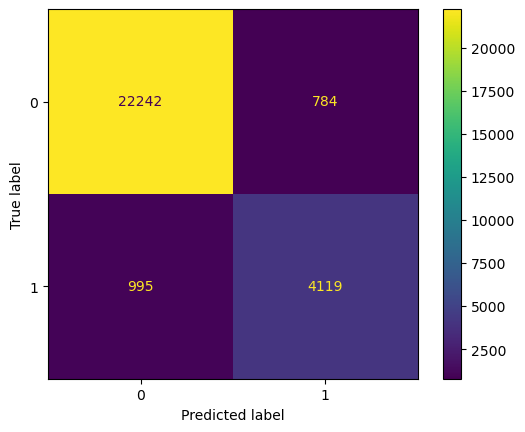

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test, labels = catboost_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = catboost_model.classes_)
disp.plot();

**True Negatives (TN): 22,242**

    The number of correctly classified negative cases (class 0 predicted as 0).

**False Positives (FP): 784**

     The number of negative cases incorrectly predicted as positive (class 0 predicted as 1).

**False Negatives (FN): 995**

    The number of positive cases incorrectly predicted as negative (class 1 predicted as 0).

**True Positives (TP): 4,119**

    The number of correctly classified positive cases (class 1 predicted as 1).

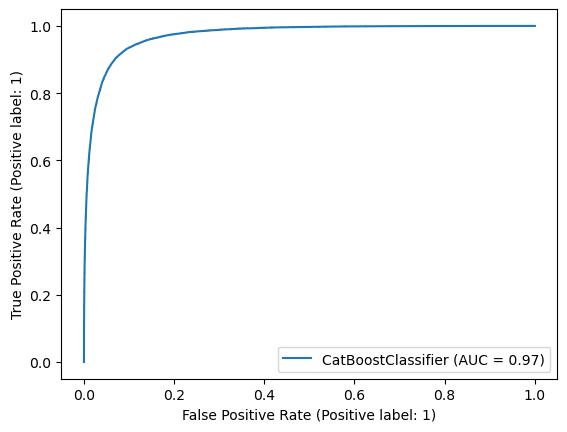

In [40]:
RocCurveDisplay.from_estimator(estimator = catboost_model, X = X_prepared , y = y)

AUC (Area Under the Curve) = 0.97: This indicates that the model has excellent discriminatory power, meaning it effectively distinguishes between the positive and negative classes. A value close to 1 suggests high performance.

## 3 Model Saving

In [73]:
# Fitting the final model on all the dataset

final_model = best_model
final_model.fit(X_prepared, y)

#Saving the Poly Convertor and the Final Model
dump(final_model,'final_mental_health_CatBoost_model.joblib')

#Loading the Model
#loaded_model = load('final_benz_price_lr_model.joblib')

['final_mental_health_CatBoost_model.joblib']